In [1]:
%%capture
!pip install sentencepiece watermark

# Imports

In [2]:
import numpy as np
import re, collections
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import sentencepiece as spm
import matplotlib.pyplot as plt

# About this notebook

Welcome to this notebook, which contains examples from the 4th chapter of our book. This chapter focuses on important concepts and techniques that are essential for pretraining a transformer model for NLP tasks. The examples presented in this notebook are designed to help you gain a deeper understanding of the underlying principles and methodologies that contribute to the success of transformer-based models.

Throughout this notebook, we will explore various topics such as denoising autoencoders, tokenization, Byte Pair Encoding (BPE), SentencePiece. Each of these concepts plays a significant role in the pretraining process of a transformer, helping to improve the model's generalization and ability to handle a wide range of languages and text data.

By working through the examples in this notebook, you will gain valuable insights and build a strong foundation for applying transformer models to real-world natural language processing tasks. Specifically in this notebook you'll find:


- Autoencoder: Implementing a simple autoencoder neural network for unsupervised learning using PyTorch. The autoencoder is composed of an encoder and a decoder, where the encoder maps input data to a lower-dimensional latent space and the decoder reconstructs the input data from the latent space representation.
- Subword tokenization: Visualizing the subword tokenization of multiple text examples. This helps to understand how tokenization techniques, such as Byte Pair Encoding (BPE) and SentencePiece, break down words into smaller units (tokens) for better generalization in natural language processing tasks.
- Byte Pair Encoding (BPE): Implementing basic BPE functions to compute character pair frequencies in a given vocabulary and merge the most frequent character pairs iteratively, thereby reducing the problem of out-of-vocabulary words and improving model generalization.


In [12]:
%load_ext watermark
%watermark -a "Nicole Koenigstein" -u -d -v -m 

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Author: Nicole Koenigstein

Last updated: 2023-04-17

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 7.34.0

Compiler    : GCC 9.4.0
OS          : Linux
Release     : 5.10.147+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit



## Denoising Autoencoder

In [6]:
# Define the autoencoder model
class Autoencoder(nn.Module):
    """
    An autoencoder neural network model for unsupervised learning, which consists of an encoder and a decoder. 
    The encoder maps input data to a lower-dimensional latent space, while the decoder reconstructs the input 
    data from the latent space representation. This class inherits from PyTorch's nn.Module.

    Attributes:
        encoder (nn.Sequential): A sequential neural network module that maps input data to a latent space
            representation. It consists of two linear layers with 128 and 64 neurons, respectively, followed 
            by ReLU activation functions.
        decoder (nn.Sequential): A sequential neural network module that reconstructs input data from the 
            latent space representation. It consists of two linear layers with 128 neurons and the original 
            input dimension (28*28), respectively, followed by a ReLU activation function for the first layer 
            and a Sigmoid activation function for the final layer.

    Usage:
        autoencoder = Autoencoder()
        output = autoencoder(input_data)
    """
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [7]:
# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 326855645.44it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 30163270.37it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 135282097.66it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 8137773.93it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [8]:
# Initialize the autoencoder and optimizer
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
num_epochs = 10
for epoch in range(num_epochs):
    for data in trainloader:
        img, _ = data
        noisy_img = img + 0.3 * torch.randn(img.shape)
        noisy_img = np.clip(noisy_img, 0., 1.)
        img = img.view(img.size(0), -1)
        noisy_img = noisy_img.view(noisy_img.size(0), -1)
        output = model(noisy_img)
        loss = criterion(output, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Test with a single image
model.eval()
test_img, _ = trainset[0]
noisy_test_img = test_img + 0.3 * torch.randn(test_img.shape)
noisy_test_img = np.clip(noisy_test_img, 0., 1.)
test_img = test_img.view(1, -1)
noisy_test_img = noisy_test_img.view(1, -1)
output_img = model(noisy_test_img)


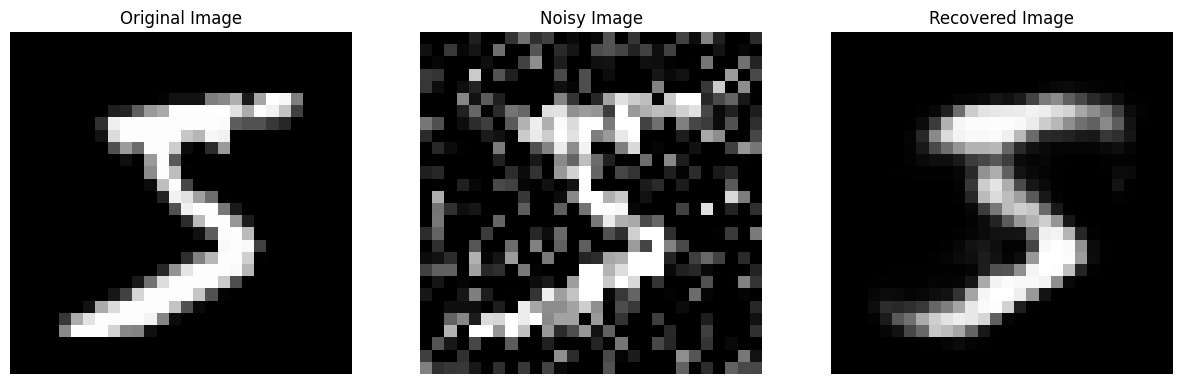

In [9]:
def plot_images(original, noisy, recovered):
    """
    Plots three images side-by-side: the original image, a noisy version of the original image,
    and the recovered image after processing through an autoencoder or other denoising method.

    Args:
        original (torch.Tensor): A PyTorch tensor representing the original image.
        noisy (torch.Tensor): A PyTorch tensor representing the noisy version of the original image.
        recovered (torch.Tensor): A PyTorch tensor representing the recovered image after denoising.

    Returns:
        None. Displays the images side-by-side in a single row using matplotlib.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    img_list = [original, noisy, recovered]
    titles = ['Original Image', 'Noisy Image', 'Recovered Image']

    for i, (img, title) in enumerate(zip(img_list, titles)):
        img = img.detach().numpy().reshape(28, 28)
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(title)
        axes[i].axis('off')

    plt.show()

# Call the new plotting function
plot_images(test_img, noisy_test_img, output_img)


# Examples for "Dealing with language related challenges"

## SentencePiece

In [3]:
# Toy sentences from The Hitchhiker's Guide to the Galaxy
sentences = [
    "The Answer to the Ultimate Question of Life, the Universe, and Everything is 42.",
    "The Babel fish is small, yellow, leech-like, and probably the oddest thing in the universe.",
    "A towel is about the most massively useful thing an interstellar hitchhiker can have.",
    "The Earth is demolished to make way for a new hyperspace bypass.",
    "Transformers are widely used in machine translation tasks.",
    "Multilingual transformers have shown great success in natural language processing.",
    "Transformers have taken the world of artificial intelligence by storm.",
]

# Save sentences to a text file
with open("hitchhikers_sentences.txt", "w") as f:
    for sentence in sentences:
        f.write(sentence + "\n")

# Train SentencePiece tokenizer
spm.SentencePieceTrainer.train(input="hitchhikers_sentences.txt", model_prefix="hitchhikers", vocab_size=100)

# Load trained tokenizer
tokenizer = spm.SentencePieceProcessor()
tokenizer.load("hitchhikers.model")

# Subword regularization and BPE-dropout
word = "transformers"
tokenized_word_examples = []
for n in range(5):
    tokenized_word_examples.append(tokenizer.encode(word, out_type=str, enable_sampling=True, alpha=0.5, nbest_size=-1))

# Print tokenized word examples
for example in tokenized_word_examples:
    print(example)


['▁t', 'r', 'an', 's', 'f', 'or', 'm', 'er', 's']
['▁t', 'r', 'an', 's', 'f', 'or', 'm', 'er', 's']
['▁t', 'r', 'a', 'n', 's', 'f', 'or', 'm', 'er', 's']
['▁', 't', 'r', 'a', 'n', 's', 'f', 'or', 'm', 'er', 's']
['▁t', 'r', 'an', 's', 'f', 'or', 'm', 'er', 's']


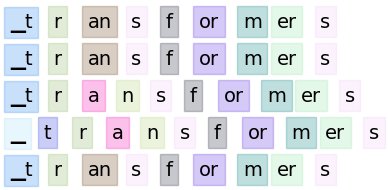

In [4]:
def plot_subword_tokenization(tokenized_word_examples):
    """
    Visualizes the subword tokenization of multiple examples using different colors for each unique token.
    The function takes a list of lists containing tokenized word examples and plots them with unique
    colors for each token.

    Args:
        tokenized_word_examples (List[List[str]]): A list of lists containing tokenized word examples,
            where each inner list contains the subword tokens of a word.

    Returns:
        None. Displays the visualization of subword tokenization using matplotlib.
    """

    fig, ax = plt.subplots(len(tokenized_word_examples), figsize=(4.5, len(tokenized_word_examples) * 0.4))

    # Create a custom color scheme
    np.random.seed(9)
    num_colors = sum(len(example) for example in tokenized_word_examples)
    colors = np.random.rand(num_colors, 3)
    

    # Assign a unique color to each token
    unique_tokens = set(token for example in tokenized_word_examples for token in example)
    token_colors = {token: colors[idx] for idx, token in enumerate(unique_tokens)}

    for i, tokens in enumerate(tokenized_word_examples):
        x_position = 0
        for token in tokens:
            color = token_colors[token]
            ax[i].text(x_position, 0.1, token, fontsize=14, bbox=dict(facecolor=color, edgecolor=color, alpha=0.25))
            x_position += (len(token) * 0.04) + 0.1  # Adjust spacing between tokens
        ax[i].axis("off")

    plt.tight_layout()
    plt.show()

plot_subword_tokenization(tokenized_word_examples)


## Byte Pair Encoding

In [5]:
def get_stats(vocab):
    """
    Computes the frequency of character pairs (bigrams) in a given vocabulary.

    Args:
        vocab (dict): A dictionary with space-separated words as keys and their frequencies as values.

    Returns:
        pairs (collections.defaultdict): A defaultdict that stores character pairs as keys and
            their frequencies as values.
    """

    pairs = collections.defaultdict(int)
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols) - 1):
            pairs[symbols[i], symbols[i + 1]] += freq
    return pairs

def merge_vocab(pair, v_in):
    """
    Merges a given character pair in the words of a vocabulary.

    Args:
        pair (tuple): A tuple containing the character pair to be merged.
        v_in (dict): A dictionary with space-separated words as keys and their frequencies as values.

    Returns:
        v_out (dict): A dictionary with the same keys as v_in, but with the character pair merged
            in the words.
    """
    
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word]
    return v_out

vocab = {'l o w </w>': 5, 'l o w e r </w>': 2,
         'n e w e s t </w>': 6, 'w i d e s t </w>': 3}
num_merges = 10
for i in range(num_merges):
    pairs = get_stats(vocab)
    if not pairs:  
        break
    best = max(pairs, key=pairs.get)
    vocab = merge_vocab(best, vocab)
    print(best)


('e', 's')
('es', 't')
('est', '</w>')
('l', 'o')
('lo', 'w')
('n', 'e')
('ne', 'w')
('new', 'est</w>')
('low', '</w>')
('w', 'i')
